# SVM with linear kernel

The goal of this notebook is to find the best parameters for linear kernel. We also want to check if the parameters depend on stock.

Linear kernel is a function: $\langle x, x'\rangle$.

We will use [sklearn.svm](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) library to perform calculations. We want to pick the best parameters for **SVC**:

* C (default 1.0)

In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as md
from statsmodels.distributions.empirical_distribution import ECDF
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn import svm
import warnings

from lob_data_utils import lob

sns.set_style('whitegrid')

warnings.filterwarnings('ignore')

# Data

We use data from 5 stocks (from dates 2013-09-01 - 2013-11-16) for which logistic regression yielded the best results.

We selected 3 subsets for each stock:
* training set (60% of data)
* test set (20% of data)
* cross-validation set (20% of data)

In [2]:
stocks = ['10795', '12098', '11618', '1243', '11234']

dfs = {}
dfs_cv = {}
dfs_test = {}

for s in stocks:
    df, df_cv, df_test = lob.load_prepared_data(s, cv=True)
    dfs[s] = df
    dfs_cv[s] = df_cv
    dfs_test[s] = df_test

Training set length for 10795: 3030
Testing set length for 10795: 1010
Cross-validation set length for 10795: 1010
Training set length for 12098: 3030
Testing set length for 12098: 1010
Cross-validation set length for 12098: 1010
Training set length for 11618: 3030
Testing set length for 11618: 1010
Cross-validation set length for 11618: 1010
Training set length for 1243: 3030
Testing set length for 1243: 1010
Cross-validation set length for 1243: 1010
Training set length for 11234: 3030
Testing set length for 11234: 1010
Cross-validation set length for 11234: 1010


In [3]:
dfs[stocks[0]].head(5)

,Unnamed: 0,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
1010,2013-09-10 09:34:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1525.0, 1410.0), (1526.0, 3511.0), (1527.0, ...",1523.0,1525.0,1524.0,1410.0,1032.0,1.0,-0.154791
1011,2013-09-10 09:35:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 3811.0), (1527.0, 3759.0), (1528.0, ...",1523.0,1526.0,1524.5,3811.0,3889.0,1.0,0.010130
1012,2013-09-10 09:36:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1526.0, 476.0), (1527.0, 3703.0), (1528.0, 6...",1525.0,1526.0,1525.5,476.0,757.0,1.0,0.227899
1013,2013-09-10 09:37:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1527.0, 419.0), (1528.0, 3608.0), (1529.0, 3...",1525.0,1527.0,1526.0,419.0,3116.0,0.0,0.762942
1014,2013-09-10 09:41:00,"[(1000.0, 6000.0), (1020.0, 500.0), (1180.0, 1...","[(1524.0, 1781.0), (1525.0, 11186.0), (1526.0,...",1523.0,1524.0,1523.5,1781.0,1207.0,1.0,-0.192102


In [4]:
def svm_classification(d, kernel, gamma='auto', C=1.0, degree=3, coef0=0.0, decision_function_shape='ovr'):
    clf = svm.SVC(kernel=kernel, gamma=gamma, C=C, degree=degree, coef0=coef0, 
                  decision_function_shape=decision_function_shape)
    X = d['queue_imbalance'].values.reshape(-1, 1)
    y = d['mid_price_indicator'].values.reshape(-1, 1)
    clf.fit(X, y)
    return clf

# Methodology

We will use at first naive approach to grasp how each of the parameter influences the ROC area score and what values make sense, when the other parameters are set to defaults. For the **linear** kernel according to documentation it's worth to check only the **C** parameter.

### C parameter

The C parameter has influence over margin picked by SVM:
* for large values of **C** SVM will choose a smaller-margin hyperplane, which means that more data points will be classified correctly
* for small values of **C** SVM will choose a bigger-margin hyperplane, so there may be more misclassifications

At first we tried parameters: [0.0001, 0.001, 0.01, 0.1, 1, 10, 1000], but after first calculations it seems that it wasn't enough, so a few more values were introduced.

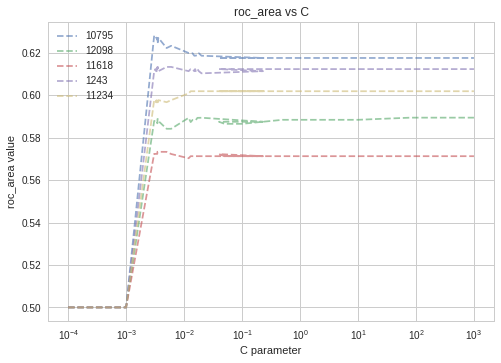

In [5]:
cs = [0.0001, 0.001, 0.00305, 0.0031, 0.0032, 0.0033, 
      0.00335, 0.00337, 0.00338, 0.00339, 0.0034, 0.00342, 0.00345,
      0.00347, 0.00348,  0.00349,
      0.0035, 0.00352, 0.0036, 0.005, 0.006, 
      0.012, 0.013, 0.014, 0.015, 0.0155, 0.016, 
      0.017, 0.018, 0.02, 0.23, 0.04, 0.05, 0.06,
      0.1, 0.5, 1, 1.5, 10, 80, 85, 90, 93, 94, 95, 96, 97, 98, 
      99, 100, 101, 110, 1000]

df_css = {}

ax = plt.subplot()
ax.set_xscale("log", basex=10)
for s in stocks:
    df_cs = pd.DataFrame(index=cs)
    df_cs['roc'] = np.zeros(len(df_cs))
    for c in cs:
        reg_svm = svm_classification(dfs[s], 'linear', C=c)
        pred_svm_out_of_sample = reg_svm.predict(dfs_cv[s]['queue_imbalance'].values.reshape(-1, 1))
        logit_roc_auc = roc_auc_score(dfs_cv[s]['mid_price_indicator'], pred_svm_out_of_sample)
        df_cs.loc[c] = logit_roc_auc
    plt.plot(df_cs, linestyle='--', label=s, marker='x', alpha=0.6)
    df_css[s] = df_cs
plt.legend()
plt.xlabel('C parameter')
plt.ylabel('roc_area value')
plt.title('roc_area vs C')

In [6]:
for s in stocks:
    idx = df_css[s]['roc'].idxmax()
    print('For {} the best is {}'.format(s, idx))

For 10795 the best is 0.00305
For 12098 the best is 80.0
For 11618 the best is 0.00347
For 1243 the best is 0.00338
For 11234 the best is 0.013


In [7]:
for s in stocks:
    err_max = df_css[s]['roc'].max()
    err_min = df_css[s]['roc'].min()
    print('For {} the diff between best and worst {}'.format(s, err_max - err_min))

For 10795 the diff between best and worst 0.12806689621249379
For 12098 the diff between best and worst 0.08940864960282435
For 11618 the diff between best and worst 0.0733137254901961
For 1243 the diff between best and worst 0.11331372549019603
For 11234 the diff between best and worst 0.10186329312542908


# Results

We compare results of SVMs with the best choice of **C** parameter against the logistic regression and SVM with defaults.

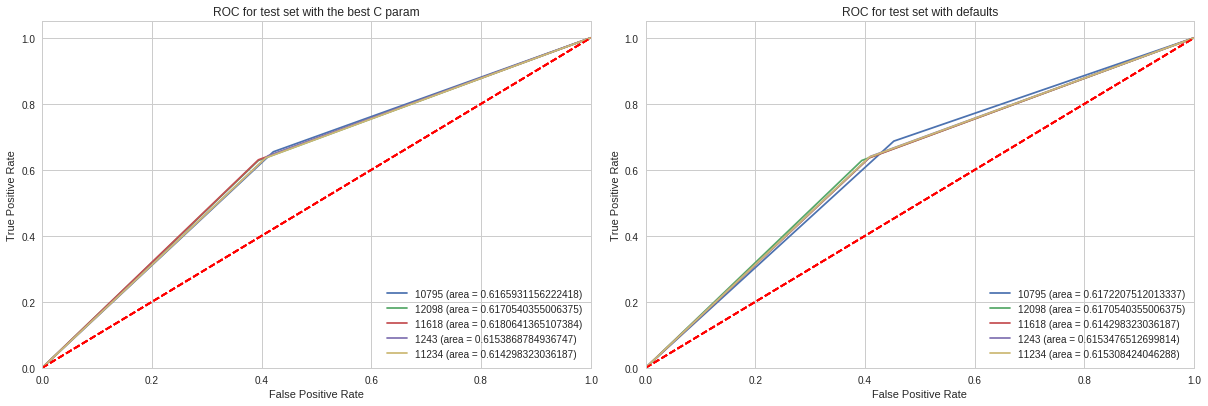

In [8]:
df_results = pd.DataFrame(index=stocks)
df_results['logistic'] = np.zeros(len(stocks))
df_results['linear-default'] = np.zeros(len(stocks))
df_results['linear-tunned'] = np.zeros(len(stocks))
df_results['C'] = np.zeros(len(stocks))

plt.subplot(121)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear', C=df_css[s].idxmax())
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with the best C param')
    df_results['linear-tunned'][s] = roc_score
    df_results['C'][s] = df_css[s].idxmax()

plt.subplot(122)
for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s, title='ROC for test set with defaults')
    df_results['linear-default'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

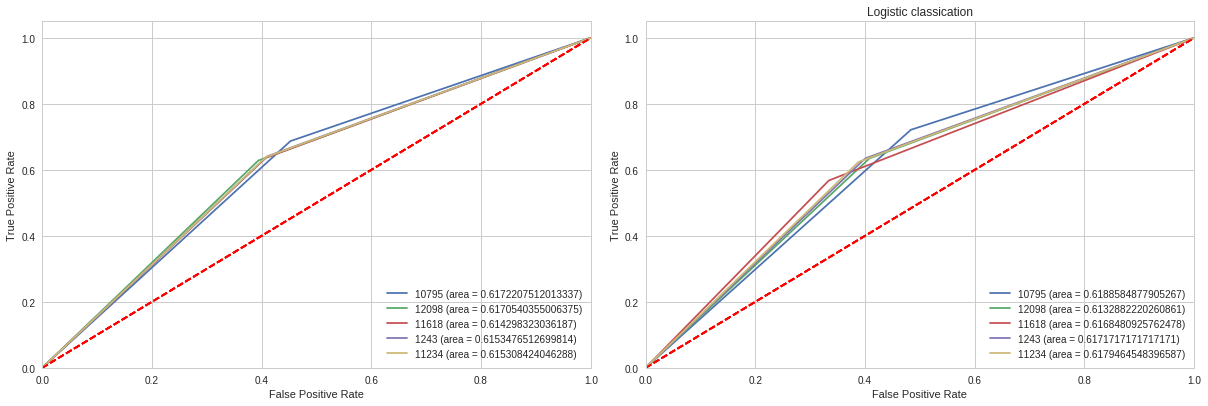

In [9]:
plt.subplot(121)

for s in stocks:
    reg_svm = svm_classification(dfs[s], 'linear')
    roc_score = lob.plot_roc(df_test, reg_svm, stock=s)
    df_results['linear-tunned'][s] = roc_score

plt.subplot(122)
for s in stocks:
    reg_log = lob.logistic_regression(dfs[s], 0, len(dfs[s]))
    roc_score = lob.plot_roc(df_test, reg_log, stock=s, title='Logistic classication')
    df_results['logistic'][s] = roc_score

plt.subplots_adjust(left=0, wspace=0.1, top=1, right=2)

In [10]:
df_results

,logistic,linear-default,linear-tunned,C
10795,0.618858,0.617221,0.617221,0.00305
12098,0.613288,0.617054,0.617054,80.00000
11618,0.616848,0.614298,0.614298,0.00347
1243,0.617172,0.615348,0.615348,0.00338
11234,0.617946,0.615308,0.615308,0.01300


# Conclusions

In our case SVM with **linear** kernel works the best for small values of **C** parameter. Choice of this parameter should vary between stocks - usually value between 0.005 - 0.5 is a good choice. It means that being tolerant to misclassifications makes our classificator to yield better results.

The results for SVM with default **C** parameter for testing set are sometimes better, than for SVMs with parameter **C** learned on cross-validation set, but still - the default value of **C** is also small.